<h2 style="color: red;"><p><u>To visualize clusters in single cell expression data</u></p></h2>

In [1]:
import numpy as np
from numpy_simulator import Sim
import time
from src.techinical_noise import AddTechnicalNoise
from sklearn.decomposition import PCA     
from sklearn.manifold import TSNE    
import matplotlib.pyplot as plt
import scanpy as sc
import sc3s
from umap import UMAP

In [2]:
import json
 
# Opening JSON file
with open("./data/data_sets_sergio.json") as json_file:
    data_sets = json.load(json_file)
data_sets    

{'DS1': ['SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Interaction_cID_4.txt',
  'SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Regs_cID_4.txt',
  0.01,
  0.8,
  1,
  4.8,
  0.3,
  20,
  82,
  100,
  9],
 'DS2': ['SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Interaction_cID_5.txt',
  'SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Regs_cID_5.txt',
  0.01,
  0.8,
  1,
  6,
  0.4,
  12,
  80,
  400,
  9],
 'DS3': ['SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Interaction_cID_6.txt',
  'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Regs_cID_6.txt',
  0.01,
  0.8,
  1,
  7,
  0.4,
  12,
  80,
  12000,
  9]}

In [9]:
NUM_SIM_CELLS = 500

def plot_labelled_dimentionality_reduction(xy, num_cell_types, num_sim_cells):
    anno = np.concatenate([np.array([str(x)] * num_sim_cells, dtype=object) for x in range(num_cell_types)], axis=0)
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot()
    colormap = plt.get_cmap("Paired")
    for i, clust in enumerate(np.sort(np.unique(anno))):
        idx = np.where(anno == clust)[0]
        ax.scatter(xy[idx, 0], xy[idx, 1], color = colormap(i), label = clust)
    ax.legend()
    plt.show()
    
    
def extract_dataset_info(dataset):
    interactions_filename, regulators_filename, noises, num_genes, num_cell_types = dataset[0], dataset[1], dataset[2:-2], int(dataset[-2]), int(dataset[-1])
    outlier_genes_noises = tuple(noises[0:3])
    library_size_noises = tuple(noises[3:5])
    dropout_noises = tuple(noises[5:7])
    return interactions_filename, regulators_filename, noises, num_genes, num_cell_types, outlier_genes_noises, library_size_noises, dropout_noises


def debug_datasets(dataset: list, pca=True, pca_components=2, umap=True):
    """ give the json dataset information and it will show pca plot """
    
    interactions_filename, regulators_filename, noises, num_genes, num_cell_types, outlier_genes_noises, library_size_noises, dropout_noises = extract_dataset_info(dataset)
    
    start = time.time()
    sim = Sim(num_genes=num_genes, num_cells_types=num_cell_types, num_cells_to_simulate=50, interactions=interactions_filename, regulators=regulators_filename, noise_amplitude=0.7)
    sim.run()
    expr_clean = sim.x
    print(expr_clean.shape)
    print(f"took {time.time() - start} seconds")

    expr = AddTechnicalNoise(num_genes, num_cell_types, expr_clean.shape[0], outlier_genes_noises, library_size_noises, dropout_noises).get_noisy_technical_concentration(expr_clean.T)
    print(f"shape noisy data: {expr.shape}")
    expr = expr.T
    
    if pca or umap:
        counts = expr/(np.sum(expr, axis = 1)[:, None] + 1e-6)* 100
        counts = np.log1p(expr)
    
    x_pca = None
    if pca:
        x_pca = pca = PCA(n_components = pca_components).fit_transform(counts)
        plot_labelled_dimentionality_reduction(x_pca, num_cell_types, NUM_SIM_CELLS)
    
    if umap:
        if x_pca is None:
            xy_umap = UMAP(n_components = 2).fit_transform(counts)
        else:
            xy_umap = UMAP(n_components = 2).fit_transform(x_pca)
        plot_labelled_dimentionality_reduction(xy_umap, num_cell_types, NUM_SIM_CELLS)
        
    return expr    

**DS1**
['SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Interaction_cID_4.txt', 'SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Regs_cID_4.txt', 0.01, 0.8, 1, 4.8, 0.3, 20, 82, 100, 9]
sampling time steps:  500
layer:  0
layer:  1
layer:  2
(500, 100, 9)
took 0.13947439193725586 seconds
shape noisy data: (100, 4500)


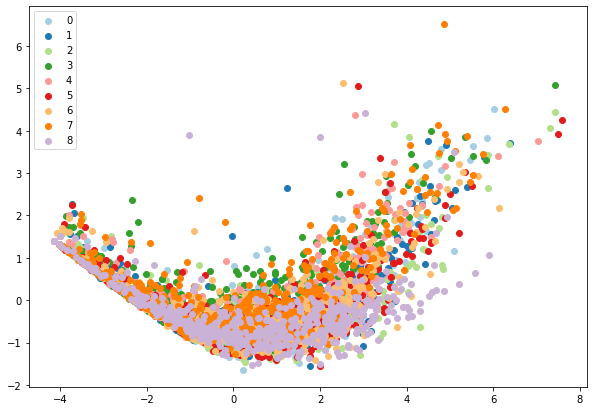

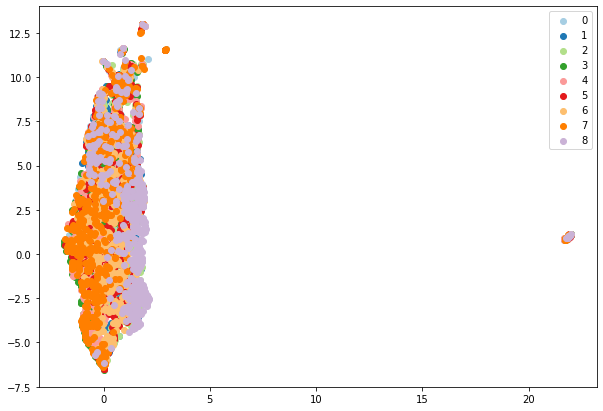

**DS2**
['SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Interaction_cID_5.txt', 'SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Regs_cID_5.txt', 0.01, 0.8, 1, 6, 0.4, 12, 80, 400, 9]
sampling time steps:  500
layer:  0
layer:  1
layer:  2
layer:  3
layer:  4
layer:  5
(500, 400, 9)
took 0.43053174018859863 seconds
shape noisy data: (400, 4500)


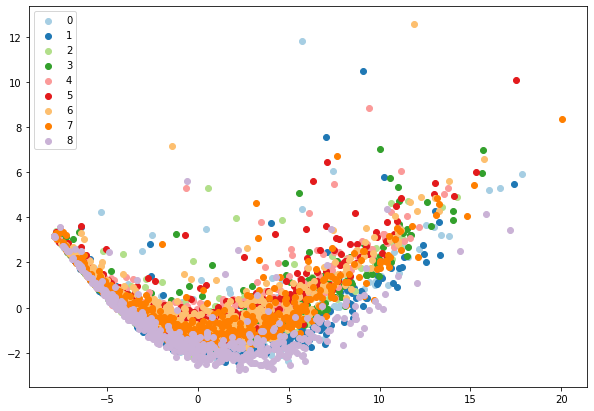

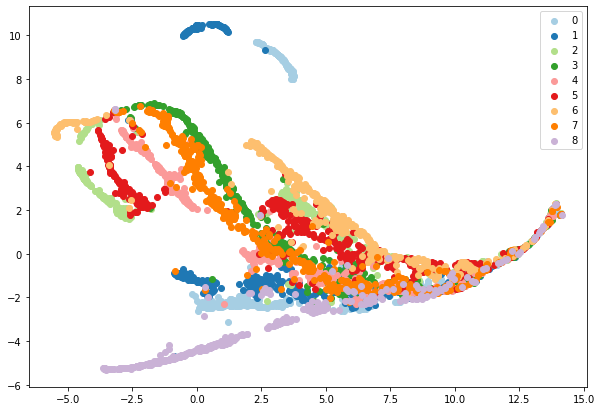

**DS3**
['SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Interaction_cID_6.txt', 'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Regs_cID_6.txt', 0.01, 0.8, 1, 7, 0.4, 12, 80, 12000, 9]
sampling time steps:  500
layer:  0
layer:  1
layer:  2
layer:  3
layer:  4
layer:  5
layer:  6
(500, 12000, 9)
took 1.3746066093444824 seconds
shape noisy data: (12000, 4500)


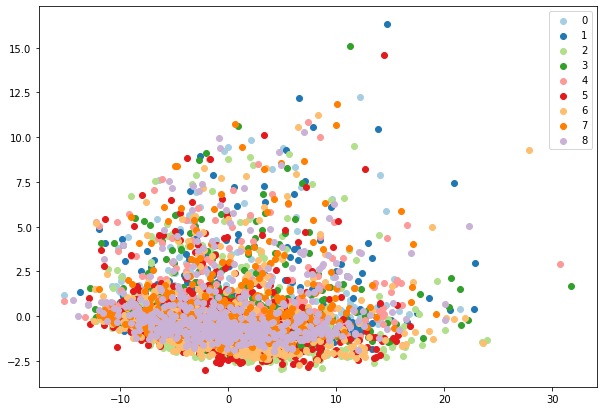

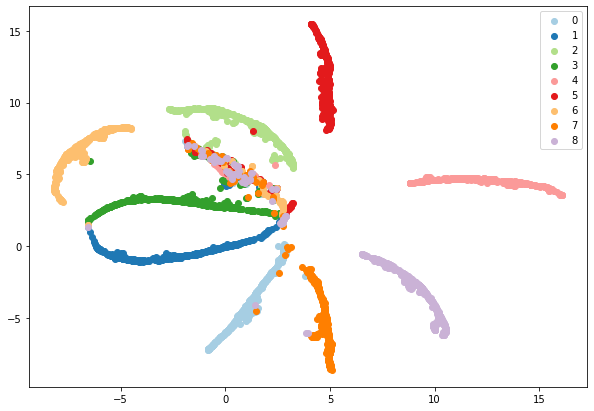

In [11]:
counts_data_sets = {}
for key, val in data_sets.items():
    print(f"**{key}**")
    print(val)
    expr = debug_datasets(val, pca_components=10)
    counts_data_sets[key] = expr

## distance matrix

In [13]:
from scipy.spatial import distance_matrix

In [27]:
ds1 = counts_data_sets["DS1"]
distance_matrix(ds1[:5], ds1[6:11])

array([[ 8.06225775,  7.41619849, 10.77032961,  7.28010989, 17.34935157],
       [ 7.41619849,  4.79583152,  9.48683298,  5.56776436, 16.76305461],
       [ 6.78232998,  4.69041576,  9.64365076,  4.69041576, 17.08800749],
       [ 6.70820393,  5.        ,  9.89949494,  4.58257569, 17.34935157],
       [ 7.34846923,  4.69041576,  9.43398113,  5.47722558, 16.73320053]])